In [24]:
# We will need these so we can reload modules as we modify them
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
%%writefile MRJob5_4_1.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class stripes(MRJob):
    
    """
    Build stripes
    - Read in basis words from basisWords.txt
    - For each 5-gram:
       - Deduplicate the words in the 5-gram, then sort alphabetically
       - Extract count
       - Build stripe: (word1, {word2: x, word3: y, ...})
       
    """
    
    def mapper_buildStripe_init(self):
        self.numDocuments = 0
        self.vocab = set()
        with open('basisWords.txt','r') as myfile:
            for word in myfile:
                self.vocab.add(word.strip())
        
    def mapper_buildStripe(self, _, line):
        fields = line.strip().split('\t')
        words = fields[0].lower().split()
        wordList = sorted(list(set(words)))
        count = float(fields[1])
        self.numDocuments += count
        for index1 in range(len(wordList)-1):
            stripe = {}
            if wordList[index1] in self.vocab:
                for index2 in range(index1+1,len(wordList)):
                    if wordList[index2] in self.vocab:
                        stripe[wordList[index2]] = count
            if len(stripe) > 0:
                yield wordList[index1], stripe
                
    def mapper_buildStripe_final(self):
        yield '*total', {'*total':self.numDocuments}
            
    def combiner_buildStripe(self, key, values):
        stripe = {}
        for val in values:
            for word in val:
                if word in stripe:
                    stripe[word] += val[word]
                else:
                    stripe[word] = val[word]
        yield key, stripe
        
    def reducer_buildStripe_init(self):
        self.numDocs = 0
    
    def reducer_buildStripe(self, key, values):
        stripe = {}
        for val in values:
            for word in val:
                if word in stripe:
                    stripe[word] += val[word]
                else:
                    stripe[word] = val[word]
        if key == '*total':
            self.numDocs = stripe['*total']
        else:
            for word in stripe:
                stripe[word] /= self.numDocs
            yield key, stripe
    
            
        
    """
    Multi-step pipeline definitions
    Based on user input when calling runner function
    """
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_buildStripe_init,
                   mapper=self.mapper_buildStripe,
                   mapper_final=self.mapper_buildStripe_final,
                   combiner=self.combiner_buildStripe,
                   reducer_init=self.reducer_buildStripe_init,
                   reducer=self.reducer_buildStripe,
                   jobconf={'mapred.reduce.tasks': 1})
        ]
    

if __name__ == '__main__':
    stripes.run()

Overwriting MRJob5_4_1.py


In [79]:
from MRJob5_4_1 import stripes

def runJob5_4_1(filename, s3bucket, basis):

    #mr_job = stripes(args=[filename, '--file', basis])
    mr_job = stripes(args=[filename, '-r', 'hadoop', '--hadoop-home', '/usr/', '--file', basis])
    
    with mr_job.make_runner() as runner: 
        # Run MRJob
        runner.run()

        # Write stream_output to file
        for line in runner.stream_output():
            out = mr_job.parse_output_line(line)

In [80]:
myfile = './filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt'
#myfile = './filtered-5Grams/short-5gram.txt'
#myfile = 'outputUnit.txt'
mybasis = 'basisWords.txt'
output_bucket = 'none'

output = runJob5_4(myfile, output_bucket, mybasis)



alternate {'viewing': 1.6005761449506742e-06} 

alzheimer's {'dementia': 3.532979051659415e-06} 

amidst {'tumult': 1.5615377023909016e-06, 'restless': 8.393265150351096e-07} 

ammonium {'hydroxide': 1.522499259831129e-06} 

anemia {'pernicious': 1.1321148342334037e-06} 

annum {'thereon': 1.3468262683121526e-06} 

approximated {'subcutaneous': 2.3423065535863526e-06} 

architectural {'decoration': 8.978841788747684e-07} 

articular {'cartilage': 9.954802852741998e-07} 

authoritative {'interpreter': 9.759610639943135e-07} 

balcony {'overlooking': 2.7131717579041916e-06} 

bottles {'necks': 1.2687493831926076e-06} 

brightest {'diamond': 1.3858647108719252e-06} 

bursting {'shells': 1.0735571703937448e-06} 

canons {'commonest': 8.393265150351096e-07} 

careless {'hasty': 1.1321148342334037e-06} 

cartilage {'localized': 9.954802852741998e-07} 

ce {'qui': 9.36922621434541e-07} 

commence {'qui': 1.229710940632835e-06, 'palestinian': 1.2101917193529487e-06} 

commonplace {'feathers': 

In [95]:
from itertools import combinations

with open('outputUnit.txt','r') as myfile:
    for line in myfile:
        fields = line.strip().split('\t')
        stripe = eval(fields[1])
        pairs = combinations(sorted(stripe.keys()),2)

        for item in pairs:
            i = (stripe[item[0]] > 0) + 0
            j = (stripe[item[1]] > 0) + 0
            print (item[0], item[1]), (i and j, i, j)

('X', 'Y') (1, 1, 1)
('X', 'Z') (1, 1, 1)
('Y', 'Z') (1, 1, 1)
('X', 'Y') (1, 1, 1)
('M', 'N') (1, 1, 1)
('M', 'Z') (1, 1, 1)
('N', 'Z') (1, 1, 1)


In [108]:
with open('outputUnit.txt', 'r') as myfile:
    for line in myfile:
        key, value = line.strip().split('\t')
        value = eval(value)
        

0 1
0 2
1 2
0 1
0 1
0 2
1 2


# 5.3

In [70]:
from MRJob5_3 import job

def runJob5_3(filename, part, s3bucket):

    #mr_job = job(args=[filename, '--part', str(part)])
    mr_job = job(args=[filename, '--part', str(part), '-r', 'hadoop', '--hadoop-home', '/usr/'])
#     mr_job = job(args=[filename, '--part', str(part), '--no-output', '--output-dir', s3bucket,
#                        '-r', 'emr', '--emr-job-flow-id', 'j-98XEIC78B7U2'])
    
    output = []

    with mr_job.make_runner() as runner: 
        # Run MRJob
        runner.run()

        # Write stream_output to file
        for line in runner.stream_output():
            output.append(mr_job.parse_output_line(line))
    
    return output

output = runJob5_3('./filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt', 4, 'none')

The have been translated as follows
 mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
mapred.reduce.tasks: mapreduce.job.reduces
mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class


In [66]:
%matplotlib inline

import numpy as np
import pandas
import matplotlib.pyplot as plt

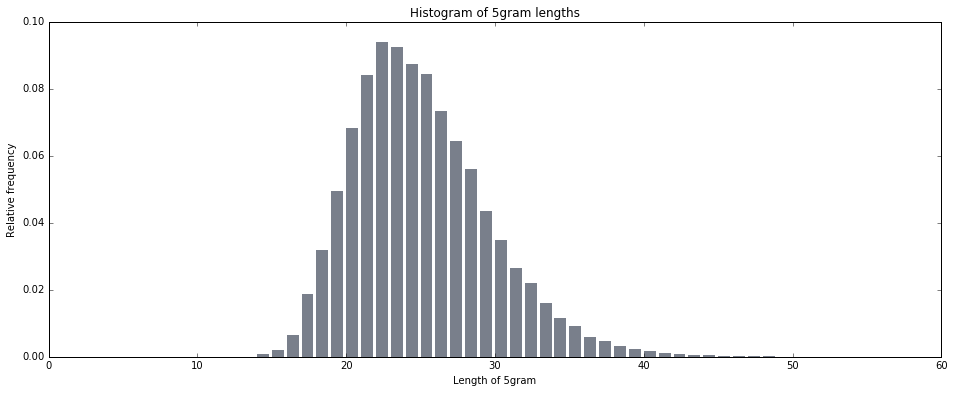

In [77]:
%matplotlib inline

import numpy as np
import pandas
import matplotlib.pyplot as plt

def plot_hist():
    frequencies = np.array(output)
    density = np.column_stack((frequencies[:,1], frequencies[:,0] / sum(frequencies[:,0])))

    plt.figure(figsize=(16, 6))
    plt.bar(density[:,0], density[:,1], color='#797f8b', edgecolor="none")
    plt.xlabel("Length of 5gram")
    plt.ylabel("Relative frequency")
    plt.title("Histogram of 5gram lengths")
    
plot_hist()